<section id="title-slide">
  <h1 class="title">The ABC of Computational Text Analysis</h1>
  <h2 class="subtitle">#10: NLP with Python</h2>
  <p class="author">Alex Flückiger</p><p class="date">08/15 May 2025</p>
</section>

## Update the course material
1. Navigate to the course folder `KED2025` using `cd` in your command line
2. Update the files with `git pull`
3. If `git pull` doesn't work due to file conflicts, run `git restore .` first

## Getting started 
1. Open VS Code
2. Windows: Make sure that you are connected to WSL (green-badge in left-lower corner)
3. Open the `KED2025` folder via the menu: `File` > `Open Folder`
4. Navigate to `KED2025/ked/materials/code/KED2025_10.ipynb` and open with double-click
5. Run the code with `Run all` via the top menu

# Overview analysis

- extract linguistic information from text automatically
- explore differences between two corpora 
    - using politcial party programmes
- visualize term frequency over time
  - using 1 August speeches by Swiss Federal Councillors

# Do Natural Language Processing (NLP)

## Modules
#### Standing of the shoulders of giants
- [spaCy](https://spacy.io/usage/spacy-101): use a classic NLP pipeline
- [pandas](https://pandas.pydata.org/docs/getting_started/intro_tutorials/index.html): analyze tabular data 
- [plotnine](https://plotnine.readthedocs.io): visualize anything (*ggplot for Python*)

# Importing modules

various ways of importing

In [1]:
# standard import
import re
import spacy

# import with a short name
import pandas as pd
import plotnine as pn
import scattertext as st

# import specific objects from a module
from pathlib import Path
from collections import Counter


# Basic NLP
Process a single document

In [2]:
# example text (to read from a file see below)
text = "Apple's CEO Tim Cook is looking at buying U.K. startup for $1 billion."

# load the English language model
# for German: de_core_news_sm
nlp = spacy.load("en_core_web_sm")

# process document (tokenizing, tagging, parsing, recognizing named entities)
doc = nlp(text)


## Linguistic features
Features per token and their linguistic dependencies

In [3]:
# visualize dependencies
spacy.displacy.render(doc, style="dep")


## Get linguistic features

In [4]:
# iterate over tokens of a document
for token in doc:
    print(
        f"{token.text:<10}", # intend by 10 characters
        "➡️",
        token.lemma_,
        token.pos_,
        token.dep_,
        token.is_alpha,
        token.is_stop, 
    )


Apple      ➡️ Apple PROPN poss True False
's         ➡️ 's PART case False True
CEO        ➡️ ceo NOUN compound True False
Tim        ➡️ Tim PROPN compound True False
Cook       ➡️ Cook PROPN nsubj True False
is         ➡️ be AUX aux True True
looking    ➡️ look VERB ROOT True False
at         ➡️ at ADP prep True True
buying     ➡️ buy VERB pcomp True False
U.K.       ➡️ U.K. PROPN nsubj False False
startup    ➡️ startup VERB ccomp True False
for        ➡️ for ADP prep True True
$          ➡️ $ SYM quantmod False False
1          ➡️ 1 NUM compound False False
billion    ➡️ billion NUM pobj True False
.          ➡️ . PUNCT punct False False


## Named Entity Recognition (NER)

In [5]:
# visualize named entities
spacy.displacy.render(doc, style="ent")


In [6]:
# iterate over named entities of a document
for ent in doc.ents:
    print(f"{ent.text:<10} ➡️ {ent.label_} ({spacy.explain(ent.label_)})")


Apple      ➡️ ORG (Companies, agencies, institutions, etc.)
Tim Cook   ➡️ PERSON (People, including fictional)
U.K.       ➡️ GPE (Countries, cities, states)
$1 billion ➡️ MONEY (Monetary values, including unit)


## Read from a file

In [7]:
# alternatively, read from a single txt file
f_text = "../data/swiss_party_programmes/txt/sp_programmes/1920_parteiprogramm_d.txt"
text = Path(f_text).read_text()

print(text[:200])


Programm der Sozialdemokratischen Partei der
Schweiz
(Angenommen durch den Parteitag vom 10./12. Dezember 1920 in Bern.)

Prinzipienerklärung.
Das Endziel der Sozialdemokratie bildet eine Gesellschaft


# Processing a collection of documents

## Steps to create a dataframe

How to make a dataframe from many text files?

1. list all files of a folder 
2. read text from each file
3. parse metadata from file name
4. create dataframe containing all documents

&rarr; wrap this all in a function `create_dataframe()`

## Define the function

In [8]:
def create_dataframe(dir_texts):
    """
    Read all documents and return a dataframe with text and metadata
    """
    indir = Path(dir_texts)  # set input directory

    data = []

    # iterate over all textfiles in input directory recursively
    for fname in indir.glob("**/*.txt"):

        print("Parsing file:", fname.name)

        text = Path(fname).read_text()
        # join lines as there are hard line-breaks
        text = text.replace("\n", " ")
        # NOTE: further modify the text here if needed

        # parse year from filename and set a metadata
        # example: 1920_parteiprogramm_d.txt --> year = 1920
        try:
            year = int(fname.name.split("_")[0])
        except ValueError:
            print("WARNING: Skip document as parsing metadata has failed:", fname.name)

        # add more metadata here if needed
        data.append({"text": text, "fname": fname.name, "year": year})

    # return a dataframe containing all documents
    return pd.DataFrame(data)


## Read and process `.txt` documents
- Call the function to create a dataframe
- process the text with spaCy

In [9]:
# get a dataframe containing all documents incl. metadata
dir_texts = "../data/swiss_party_programmes/txt/sp_programmes/"
df = create_dataframe(dir_texts)

# load German language model
nlp = spacy.load("de_core_news_sm")

# process documents efficiently (multi documents at once; batch)
df["doc"] = list(nlp.pipe(df["text"]))

# process documents one-by-one
# df["doc"] = df["text"].apply(lambda text: nlp(text))

Parsing file: 1920_parteiprogramm_d.txt
Parsing file: parteiprogramm_d_0_2010.txt
Parsing file: 1982_parteiprogramm_d_0.txt
Parsing file: 1904_parteiprogramm_d_0.txt
Parsing file: 1888_parteiprogramm_d_0.txt
Parsing file: 1959_parteiprogramm_d_0.txt
Parsing file: 1870_parteiprogramm_d_0.txt
Parsing file: 1935_parteiprogramm_d_0.txt


# Basic corpus statistics

In [10]:
print("# documents:", df.shape[0]) # number of rows
# apply + lambda means row-wise processing, after that we sum all numbers
print("# sentences:", df["doc"].apply(lambda doc: len(list(doc.sents))).sum())
print("# tokens:", df["doc"].apply(lambda doc: len(list(doc))).sum())


# documents: 8
# sentences: 4435
# tokens: 70182


## Export word counts
Looking at the the most frequent (lemmatized) words is a good start. 
Export the counts to a TSV file.

In [11]:
# define function with arguments to count vocabulary
def count_vocab(docs, by="lemma_", ignore_stopwords=True, ignore_punct=True, ignore_digits=True):
    """
    Count vocabulary from a list of documents.
    """
    vocab = Counter()
    for doc in docs:
        for tok in doc:
            if ignore_stopwords and tok.is_stop:
                continue
            if ignore_punct and tok.is_punct:
                continue
            if ignore_digits and tok.is_digit:
                continue

            word = tok.__getattribute__(by)

            if word.strip():
                vocab[word] += 1

    return vocab

# get lemmatized word count while ignore non-intresting tokens
# change `lemma_` to `text` for surface form
vocab = count_vocab(df["doc"], by="lemma_", ignore_stopwords=True, ignore_punct=True, ignore_digits=True)

# write to file, one word and its frequency per line
fname = "../analysis/vocab_frq.tsv"
with open(fname, "w") as f:
    for word, frq in vocab.most_common():
        line = f"{word}\t{frq}\n"
        f.write(line)

# show most common words
vocab.most_common(10)


[('sozial', 243),
 ('Schweiz', 236),
 ('Mensch', 212),
 ('SP', 196),
 ('Staat', 168),
 ('politisch', 163),
 ('wirtschaftlich', 162),
 ('Wirtschaft', 148),
 ('demokratisch', 133),
 ('Partei', 129)]

# Working with a subset of the data

Interested in a particular group of documents only?

In [12]:
# select the first document in the dataframe
first_doc = df.loc[0]

print(first_doc)
print(first_doc.text[:100])


text     Programm der Sozialdemokratischen Partei der S...
fname                            1920_parteiprogramm_d.txt
year                                                  1920
doc      (Programm, der, Sozialdemokratischen, Partei, ...
Name: 0, dtype: object
Programm der Sozialdemokratischen Partei der Schweiz (Angenommen durch den Parteitag vom 10./12. Dez


In [13]:
# create new dataframe that contains only a subset of the documents
# e.g. publication year from 1900 onwards
df_sub = df[df["year"] >= 1900]

# show number of documents in both dataframes
len(df_sub), len(df)

(6, 8)

# Key Word in Context (KWIC)

Show words in their original context

In [14]:
# define your search pattern between brackets
pattern = r"(Ausland|Inland)"
CONTEXT_LENGTH = 50 # number of characters before and after the keyword
CONTEXT_PATTERN="(.{0," + str(CONTEXT_LENGTH) + "})" # leave as is

df_matches = df["text"].str.extractall(CONTEXT_PATTERN + pattern + CONTEXT_PATTERN, re.IGNORECASE)

# iterate over matches and print them
for idx, row in df_matches.iterrows():
    print(f"{row[0]}  {row[1]}  {row[2]}")


wärts beziehen und für seine Industrieprodukte im   Ausland   Absatz suchen muss, deshalb von allen Schwankunge
 Unterstützung von in Not geratenen Schweizern im   Ausland  . Unterstützung und Förderung aller Bestrebungen, 
mit der Wirtschaft gewachsen, ihr Anteil am Brutto  inland  produkt schwankt zwischen 10 und 11 Prozent. Die G
träglichen CO2-Bilanz führt, die Abhängigkeit vom   Ausland   verringert, die Versorgungssicherheit erhöht und 
eaktion, weil die Schweiz in mancher Hinsicht vom   Ausland   abhängig und weltweiten Zwängen ausgesetzt ist. U
eren multinational. Produktionsstätten werden ins   Ausland   verlagert und einheimische Betriebe von multinati
chränkungen. Die Schweiz ist nicht nur selbst vom   Ausland   abhängig, sie schafft auch Abhängigkeiten. Wie an
ine Beschränkung der Futtermittel-lmporte aus dem   Ausland  .  39  (26) Landwirtschaftspolitik  ❑ Die Einkomme
piel einer wirksamen Massnahme. 2. Das Risiko der   Ausland  abhängigkeit der Energieversorgung soll redu

# Export results to `.txt` file

collect any information and write to file
- particular terms or linguistic constructions
- Named Entities (NE)
- ...

In [15]:
results = []

# iterate over all documents in dataset
for idx, row in df.iterrows():
    # get the analyzed spacy document
    doc = row["doc"]

    for sent in doc.sents:
        if "Armut" in sent.text:
            # match contains the sentence where the term occurs, preceded by the filename (tab-separated)
            match = f"{row['fname']}\t{sent.text}"
            results.append(match)

# write collected information to file
fname = "../analysis/sents_poverty.txt"
with open(fname, "w") as f:
    f.write("\n".join(results))

print(results[0])


1920_parteiprogramm_d.txt	Durch die Befriedigung der Bedürfnisse aller Arbeitenden und die Fürsorge der Gesellschaft für alle Arbeitsunfähigen werden Armut und Not, Verbrechen und Prostitution, die in den Zuständen des Kapitalismus ihren Nährboden fanden, als gesellschaftliche Erscheinung verschwinden.


# Export dataframe as CSV Dataset
We have created a dataframe containing all party programmes. Now, let's save it as csv dataset.

In [16]:
# export corpus as csv
f_csv = "../data/swiss_party_programmes/corpus_party_programmes.csv"
df = df.sort_values("year")
df.to_csv(f_csv)
df

,text,fname,year,doc
6,Programm und Organisation (Verfassung)der sozi...,1870_parteiprogramm_d_0.txt,1870,"(Programm, und, Organisation, (, Verfassung, )..."
4,Sozialdemokratische Partei der Schweiz Grundsä...,1888_parteiprogramm_d_0.txt,1888,"(Sozialdemokratische, Partei, der, Schweiz, Gr..."
3,Programm der Sozialdemokratischen Partei der S...,1904_parteiprogramm_d_0.txt,1904,"(Programm, der, Sozialdemokratischen, Partei, ..."
0,Programm der Sozialdemokratischen Partei der S...,1920_parteiprogramm_d.txt,1920,"(Programm, der, Sozialdemokratischen, Partei, ..."
1,Sozialdemokratische Partei der Schweiz Partei...,parteiprogramm_d_0_2010.txt,1920,"(Sozialdemokratische, Partei, der, Schweiz, ,..."
7,Programm der Sozialdemokratischen Partei der S...,1935_parteiprogramm_d_0.txt,1935,"(Programm, der, Sozialdemokratischen, Partei, ..."
5,Programm der Sozialdemokratischen Partei der S...,1959_parteiprogramm_d_0.txt,1959,"(Programm, der, Sozialdemokratischen, Partei, ..."
2,Geleitwort Dieses ist das sechste Parteiprogr...,1982_parteiprogramm_d_0.txt,1982,"(Geleitwort, , Dieses, ist, das, sechste, Par..."



# In-class: Exercises I

1. Make sure that your local copy of the Github repository KED2025 is up-to-date with `git pull`. You can find the relevant material as follows:
   - notebook `/KED2025/ked/materials/code/KED2025_10.ipynb`
   - party programmes `/KED2025/ked/materials/data/swiss_party_programmes/txt`

1. Open the notebook in VS Code. *@Windows people*: Make sure that you are connected to WSL Ubuntu (check green badge).

2. Run all the code in the notebook by clicking `Run All`.

3. Process another English sentence with spaCy instead of the one mentioning Apple.

4. Load the German language model and process a German sentence. Display the linguistic information and check the difference between the lemma and the form as it occurs in the text.

5. Play around with the code as it is a good way to learn. Modify one thing, run the code, and see if the output matches your expectations. Start easy and then get increasingly brave until the code breaks. Fix the issue and try again.


# Explore corpus of 1 August speeches interactively

![Example Scattertext](../analysis/viz_party_differences.png)

# What the graph shows
- speeches by the Swiss Federal Councilors on 1 August
- visualize the difference between speakers of *Social Democratic Party of Switzerland* (SP) and other parties
- interpretation
  -  top right: terms used by all
  -  top left: terms primarily used by SP
  -  lower right: terms primarily used by other parties
 
[Explore interactively in your browser](https://aflueckiger.github.io/KED2025/materials/analysis/viz_party_differences.html)

# Scattertext

- how does language differ between two groups
    - organization, person, gender, time etc.
- interactive exploring
- find discriminative terms
- scoring function *rank-frequency*
    - normalized by number of terms `[0,1]`

## Load CSV File

Load a dataset of 1 August speeches by Swiss federal councillors (received from Simon Schmid ex-journalist at [Republik, original article](https://www.republik.ch/2019/08/01/anleitung-fuer-die-perfekte-ansprache-zum-1-august))

In [17]:
# read dataset from csv file
f_csv = "../data/dataset_speeches_federal_council_2019.csv"
df = pd.read_csv(f_csv)

# make new column containing relevant metadata to show in interactive visualisation
df["descripton"] = df[["Redner", "Partei", "Jahr"]].astype(str).agg(", ".join, axis=1)

# filter out non-German texts or with less than 500 characters
df_sub = df[(df["Sprache"] == "de") & (df["Text"].str.len() >= 500)].copy()

# process documents efficiently (batch-wise)
df_sub["doc"] = list(nlp.pipe(df_sub["Text"]))

print("Number of speeches:", df.shape[0])

# sneak peek of dataset
df_sub.head(3)

Number of speeches: 170


,Jahr,Status,Vollständigkeit,Redner,Geschlecht,Funktion,Partei,Partei-Original,Typ,Bemerkung,Sprache,Originalsprache,Ort,Titel,Anrede,Text,Originaltext,Quelle,descripton,doc
0,2018,done,vollständig,Alain Berset,m,BP,SP,SP,BP-Rede,NaN,de,NaN,NaN,NaN,Sehr geehrte Damen und Herren,Wir leben in der Schweiz in Frieden und Wohlst...,NaN,https://www.admin.ch/gov/de/start/dokumentatio...,"Alain Berset, SP, 2018","(Wir, leben, in, der, Schweiz, in, Frieden, un..."
3,2018,done,vollständig,Doris Leuthard,f,BR,CVP,CVP,Lokal,NaN,de,NaN,Villmergen,NaN,Liebe Mitbürgerinnen und Mitbürger,Ich bedanke mich für die Einladung zu Ihrer 1....,NaN,https://www.admin.ch/gov/de/start/dokumentatio...,"Doris Leuthard, CVP, 2018","(Ich, bedanke, mich, für, die, Einladung, zu, ..."
4,2018,done,vollständig,Guy Parmelin,m,BR,SVP,SVP,Lokal,NaN,de,NaN,NaN,«Armbrust und Hellebarde»,"Sehr geehrte Eidgenossen, Meine Damen und Herren",Eine 1.-August-Rede ist eine der heikelsten rh...,NaN,https://www.admin.ch/gov/de/start/dokumentatio...,"Guy Parmelin, SVP, 2018","(Eine, 1.-August-Rede, ist, eine, der, heikels..."


## Create scattertext plot

In [18]:
censor_tags = {'NUM', 'PUNCT'} # tags to ignore in corpus, e.g. numbers

# stop words to ignore in corpus
de_stopwords = spacy.lang.de.stop_words.STOP_WORDS # default stop words
custom_stopwords = {'[', ']', '%', "*"}
de_stopwords = de_stopwords.union(custom_stopwords) # extend with custom stop words

# create corpus from dataframe
# lemmatized and lowercased terms, no stopwords, no numbers
corpus_speeches = st.CorpusFromParsedDocuments(df_sub, # dataset
                             category_col='Partei', # index differences by ...
                             parsed_col='doc', 
                             feats_from_spacy_doc=st.FeatsFromSpacyDoc(tag_types_to_censor=censor_tags, use_lemmas=True),
                             ).build().get_stoplisted_unigram_corpus(de_stopwords)

# create visualization (interactive html)
html = st.produce_scattertext_explorer(corpus_speeches,
            category='SP', # set attribute to divide corpus into two parts
            category_name='SP',
            not_category_name='other parties',
            metadata=df_sub['descripton'],
            width_in_pixels=1000,
            minimum_term_frequency=5, # drop terms occurring less than 5 times
            save_svg_button=True,    
)

# write visualization to html file
fname = "../analysis/viz_party_differences.html"
open(fname, 'wb').write(html.encode('utf-8'))

2422441

# Plot term frequencies over time

![Example](../analysis/rel_term_frq_nation.png)

## Create a group-term matrix
Aggregate term frequencies by year

In [19]:
# count vocab per group (e.g., year)
# define how groups are formed, pass each group together with the form (e.g. lemma) the function count_vocab to count the all words
df_vocab = pd.DataFrame(
    df_sub.groupby("Jahr").apply(lambda group: count_vocab(group["doc"], by="lemma_"), include_groups=False)
).reset_index()

# rename column (shape: group x aggregated vocab)
df_vocab.rename(columns={"Jahr": "year", 0: "vocab"}, inplace=True)

# extract the vocab from the dict in column `vocab` (shape: group x all terms)
exploded_vocab = pd.json_normalize(df_vocab["vocab"])

# concatenate the metadata and the exploded vocab and remove aggreated vocab
df_vocab = pd.concat([df_vocab, exploded_vocab], axis=1).drop(columns=["vocab"])

# change dataframe from horizontal to vertical shape
df_tidy = df_vocab.melt(id_vars="year", var_name="term", value_name="frequency")

# calculate the relative frequency of terms (normalize individual frequencies by year)
df_tidy["relative frequency"] = df_tidy.groupby("year")["frequency"].transform(lambda x: x / x.sum())
df_tidy

,year,term,frequency,relative frequency
0,1935,Demut,1.0,0.001422
1,1936,Demut,NaN,NaN
2,1937,Demut,NaN,NaN
3,1939,Demut,NaN,NaN
4,1940,Demut,NaN,NaN
...,...,...,...,...
1197359,2014,Schlimmeres,NaN,NaN
1197360,2015,Schlimmeres,NaN,NaN
1197361,2016,Schlimmeres,NaN,NaN
1197362,2017,Schlimmeres,NaN,NaN


## Plot frequencies over time

/home/alex/KED2025/venv/lib/python3.12/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 95 rows containing missing values.


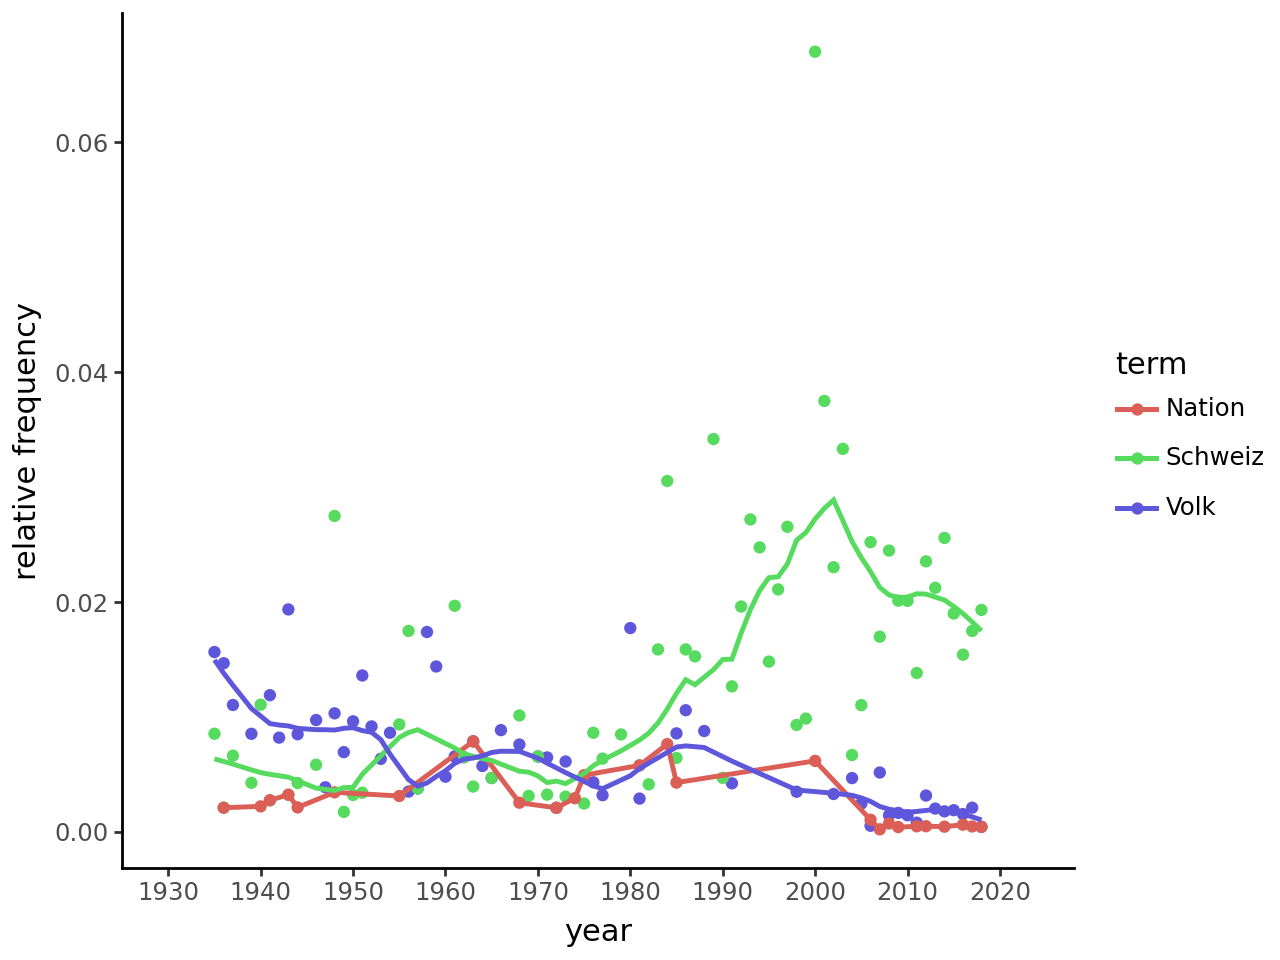

In [20]:
# filter the dataset for the following terms
terms = ["Volk", "Schweiz", "Nation"]
df_terms = df_tidy[df_tidy["term"].isin(terms)]

# plot the relative frequency for the terms above
(
    pn.ggplot(df_terms, pn.aes(x="year", y="relative frequency", color="term"))
    + pn.geom_point()  # show individual points
    + pn.stat_smooth(
        method="lowess", span=0.15, se=False
    )  # overlay points with a smoothed line
    + pn.scale_x_continuous(breaks=range(1930, 2021, 10), expand=(0, 10)) # set x-axis ticks
    + pn.theme_classic() # make the plot look nicer
)  


## Save Plot

/home/alex/KED2025/venv/lib/python3.12/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 131 rows containing missing values.
/home/alex/KED2025/venv/lib/python3.12/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 131 rows containing missing values.


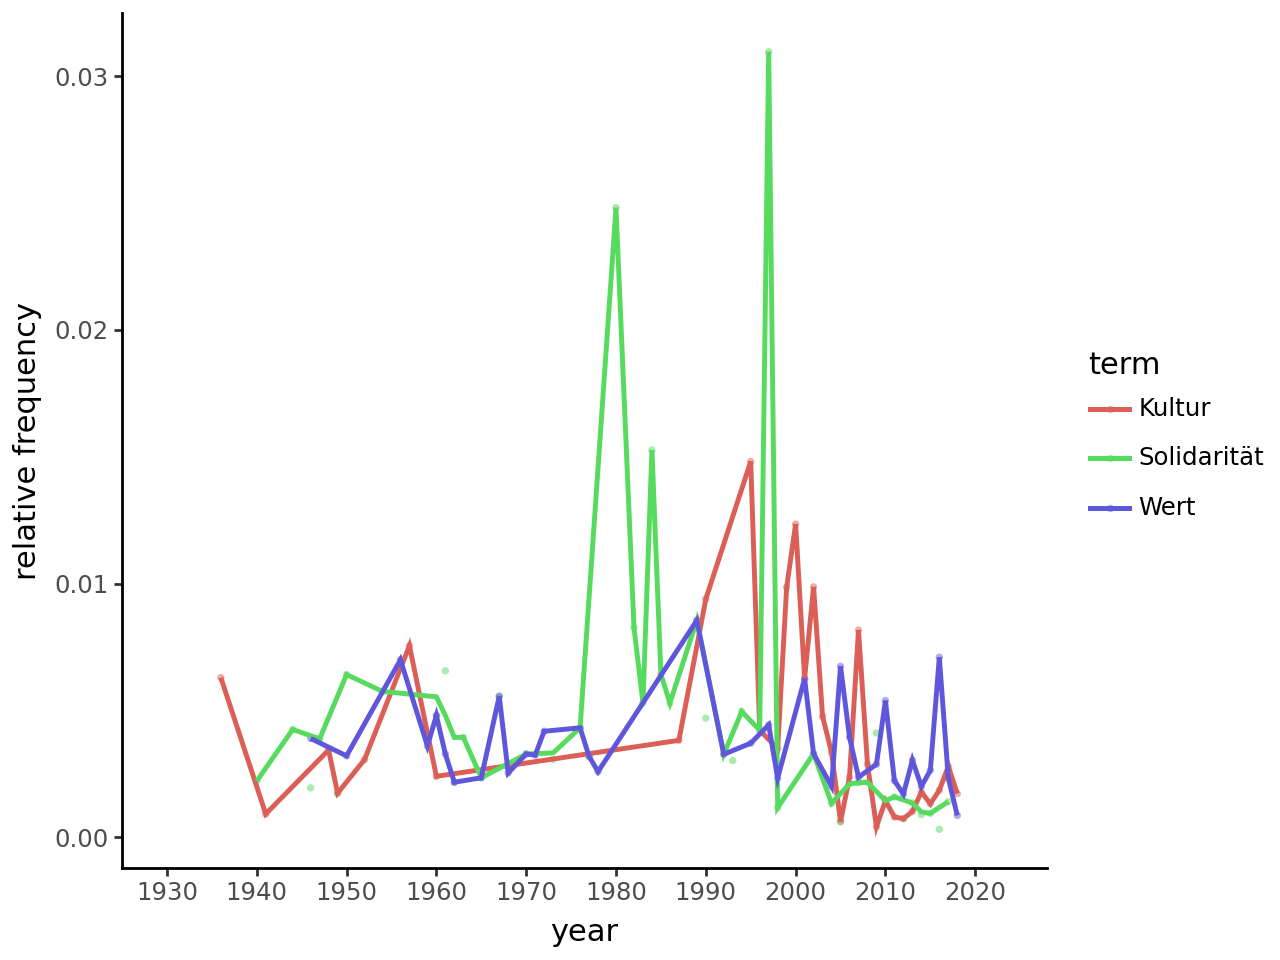

In [21]:
# check some other terms
terms = ["Solidarität", "Kultur", "Wert"]

df_terms = df_tidy[df_tidy["term"].isin(terms)]

p = (
    pn.ggplot(df_terms, pn.aes("year", "relative frequency", color="term"))
    + pn.geom_point(alpha=0.5, stroke=0)
    + pn.stat_smooth(method="lowess", span=0.10, se=False)
    + pn.scale_x_continuous(breaks=range(1930, 2021, 10), expand=(0, 10))
    + pn.theme_classic()
)

# save as png
fname = "../analysis/rel_term_frq_culture.png"
p.save(filename=fname, dpi=150, verbose=False)
p


# Number of documents per year

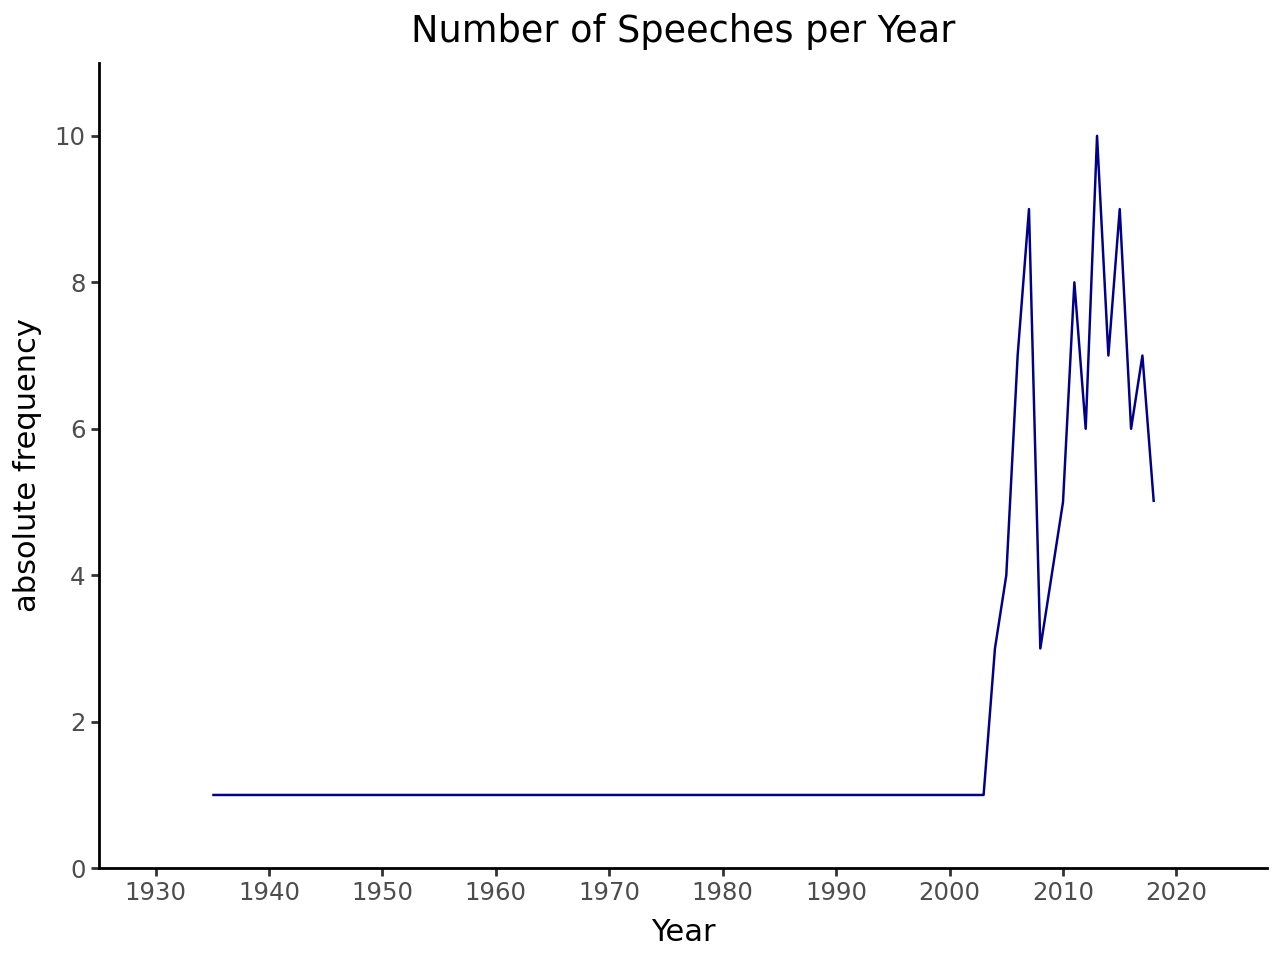

In [22]:
docs_per_year = (
    df_sub.groupby("Jahr")
    .agg({"Text": "count"})
    .reset_index()
    .rename(columns={"Text": "count"})
)

(
    pn.ggplot(docs_per_year, pn.aes(x="Jahr", y="count"))
    + pn.geom_line(color="darkblue")
    + pn.labs(title="Number of Speeches per Year", x="Year", y="absolute frequency")
    + pn.scale_y_continuous(breaks=range(0, 20, 2), expand=(0, 1))
    + pn.scale_x_continuous(breaks=range(1930, 2021, 10), expand=(0, 10))
    + pn.theme_classic()
)

# Working on mini-project

Ask questions, <br>
I am ready to help!

![Help!](../../lectures/images/help_frog.gif)

# Resources

#### tutorials for spaCy

- [official spaCy 101](https://spacy.io/usage/spacy-101)
- [official online course spaCy](https://course.spacy.io/en/chapter1)
- [Hitchhiker's Guide to NLP in spaCy](https://www.kaggle.com/nirant/hitchhiker-s-guide-to-nlp-in-spacy)